In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Input data

In [2]:
celltype = "TRB_HUMAN"
myfiles = [x for x in os.listdir(".") if x.startswith('cdr3-clones') and celltype in x]
myfiles

['cdr3-clones-DC4Balance-TRB_HUMAN-after-reassignment.csv',
 'cdr3-clones-DOMINO-TRB_HUMAN-after-reassignment.csv']

In [3]:
pt_file="20210802-RUN42-DataSheet-TCRb.csv"
run = "run42"
plotfile=run + "-similarity-" + celltype + '.pdf'
suspects_list = run + "-similarity-" + celltype + ".txt"
excel_file = run + "-similarity-" + celltype + ".xlsx"
print("Outfile:", plotfile)

Outfile: run42-similarity-TRB_HUMAN.pdf


## Import clonesdata

In [4]:
clones = pd.read_csv(myfiles[0], sep="\t")
if len(myfiles) > 1:
    for clones_file in myfiles[1:]:
        clones = pd.concat([clones, pd.read_csv(clones_file, sep="\t")])

In [5]:
clones.head()

,Sample,MID,cdr3pep,freq,uniq_umis,V_sub,J_sub,sum_sites,avg_sites,read_perc,umi_perc
0,BP-T081-Tu_S33,ACGTACGT,CSVEDGYGYTFG,212,9,TRBV29-1,TRBJ1-2,420,1.981132,2.616315,0.704777
1,BP-T081-Tu_S33,ACGTACGT,CSVKGARTEAFFG,168,9,TRBV29-1,TRBJ1-1,336,2.000000,2.073306,0.704777
2,BP-T081-Tu_S33,ACGTACGT,CSVADQLSYGYTFG,163,14,TRBV29-1,TRBJ1-2,324,1.987730,2.011601,1.096319
3,BP-T081-Tu_S33,ACGTACGT,CSVRTSGRTDTQYFG,160,24,TRBV29-1,TRBJ2-3,318,1.987500,1.974577,1.879405
4,BP-T081-Tu_S33,ACGTACGT,CASRGQGSNQPQHFG,136,7,TRBV6-1,TRBJ1-5,135,0.992647,1.678391,0.548160


In [6]:
# Summarize data on CDR3
clones = clones.groupby(by=['Sample','cdr3pep']).sum()
clones = clones.reset_index()
clones = clones.sort_values(['Sample','freq'], ascending=False)
clones.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc
194604,DO-057V1-Tph4-Tu_S2,CSGGGFTYNEQFFG,102,78,204,2.0,0.379098,0.337108
195073,DO-057V1-Tph4-Tu_S2,CSVLPGTSGENEQFFG,91,76,182,2.0,0.338215,0.328464
187550,DO-057V1-Tph4-Tu_S2,CASSLGANTEAFFG,90,73,90,1.0,0.334498,0.315498
194611,DO-057V1-Tph4-Tu_S2,CSGGQGNNEQFFG,76,59,152,2.0,0.282465,0.254992
189605,DO-057V1-Tph4-Tu_S2,CASSPLSLQPQHFG,74,61,74,1.0,0.275032,0.263636


## Import patient table

In [7]:
pt = pd.read_csv(pt_file, sep=",", skiprows=20)
pt = pt.rename(columns = {'Sample': 'SampleInfo'})
pt.head()

,Sample_ID,Sample_Name,Sample_Plate,Sample_Well,I7_Index_ID,index,I5_Index_ID,index2,Run,Nr,Sample_Project,Species,Chain,Patient,SampleInfo,UMI,HEK cells,RACE,Constant,Isotype
0,N701_S502,DO-057V1-Tfh4-Tu,NaN,NaN,NaN,NaN,NaN,NaN,run42,S1,DOMINO,human,TCRb,DO-057V1,CD4+ Tfh,yes,no,no,no,TCRb
1,N702_S502,DO-057V1-Tph4-Tu,NaN,NaN,NaN,NaN,NaN,NaN,run42,S2,DOMINO,human,TCRb,DO-057V1,CD4+ Tph,yes,no,no,no,TCRb
2,N703_S502,DO-057V1-Tfh8-Tu,NaN,NaN,NaN,NaN,NaN,NaN,run42,S3,DOMINO,human,TCRb,DO-057V1,CD8+ Tfh,yes,no,no,no,TCRb
3,N704_S502,DO-057V1-LN-Tu,NaN,NaN,NaN,NaN,NaN,NaN,run42,S4,DOMINO,human,TCRb,DO-057V1,LN biopsy,yes,no,no,no,TCRb
4,N705_S502,DO-056V1-Tfh4-Tu,NaN,NaN,NaN,NaN,NaN,NaN,run42,S5,DOMINO,human,TCRb,DO-056V1,CD4+ Tfh,yes,no,no,no,TCRb


In [8]:
# Concatenate sample-id and nr in a new column
f = lambda x,y: str(x) + "_" + str(y)
pt['Sample'] = [name for name in map(f, pt['Sample_Name'], pt['Nr'])]
pt = pt[["Sample","Patient"]]

In [9]:
pt.head()

,Sample,Patient
0,DO-057V1-Tfh4-Tu_S1,DO-057V1
1,DO-057V1-Tph4-Tu_S2,DO-057V1
2,DO-057V1-Tfh8-Tu_S3,DO-057V1
3,DO-057V1-LN-Tu_S4,DO-057V1
4,DO-056V1-Tfh4-Tu_S5,DO-056V1


## Merge clones with pt

In [10]:
# Join data frames
df = pd.merge(clones, pt, how='inner', on = 'Sample')
df.head()

,Sample,cdr3pep,freq,uniq_umis,sum_sites,avg_sites,read_perc,umi_perc,Patient
0,DO-057V1-Tph4-Tu_S2,CSGGGFTYNEQFFG,102,78,204,2.0,0.379098,0.337108,DO-057V1
1,DO-057V1-Tph4-Tu_S2,CSVLPGTSGENEQFFG,91,76,182,2.0,0.338215,0.328464,DO-057V1
2,DO-057V1-Tph4-Tu_S2,CASSLGANTEAFFG,90,73,90,1.0,0.334498,0.315498,DO-057V1
3,DO-057V1-Tph4-Tu_S2,CSGGQGNNEQFFG,76,59,152,2.0,0.282465,0.254992,DO-057V1
4,DO-057V1-Tph4-Tu_S2,CASSPLSLQPQHFG,74,61,74,1.0,0.275032,0.263636,DO-057V1


## Determine distance between samples

In [11]:
df_pivot = df.pivot_table(columns=['Patient','Sample'], index='cdr3pep', values='freq')
df_pivot = df_pivot.fillna(0)
df_pivot.head()

Patient                     DO-051V1                       \
Sample          DO-051V1-Tfh4-Tu_S24 DO-051V1-Tph4-Tu_S23   
cdr3pep                                                     
CAAAANTGELFFG                    0.0                  0.0   
CAAAASGNTGELFFG                  0.0                  0.0   
CAAAASNQPQHFG                    0.0                  0.0   
CAAAEQHYEQYFG                    0.0                  0.0   
CAAAGGWADTQYFG                   0.0                  0.0   

Patient                     DO-053V1                       \
Sample          DO-053V1-Tfh4-Tu_S21 DO-053V1-Tfh8-Tu_S22   
cdr3pep                                                     
CAAAANTGELFFG                    0.0                  0.0   
CAAAASGNTGELFFG                  0.0                  0.0   
CAAAASNQPQHFG                    0.0                  0.0   
CAAAEQHYEQYFG                    0.0                  0.0   
CAAAGGWADTQYFG                   0.0                  0.0   

Patient                                          DO-054V1  \
Sample          DO-053V1-Tph4-Tu_S20 DO-054V1-Tfh4-Tu_S18   
cdr3pep                                                     
CAAAANTGELFFG                    0.0                  0.0   
CAAAASGNTGELFFG                  0.0                  0.0   
CAAAASNQPQHFG                    0.0                  0.0   
CAAAEQHYEQYFG                    0.0                  0.0   
CAAAGGWADTQYFG                   0.0                  0.0   

Patient                                                            DO-056V1  \
Sample          DO-054V1-Tfh8-Tu_S17 DO-054V1-Tph4-Tu_S19 DO-056V1-LN-Tu_S8   
cdr3pep                                                                       
CAAAANTGELFFG                    0.0                  0.0               0.0   
CAAAASGNTGELFFG                  0.0                  0.0               0.0   
CAAAASNQPQHFG                    0.0                  0.0               0.0   
CAAAEQHYEQYFG                    0.0                  0.0               0.0   
CAAAGGWADTQYFG                   0.0                  0.0               0.0   

Patient                                  ...               P53V01  \
Sample          DO-056V1-Tfh4-Tu_S5      ...       BP-T082-Tu_S34   
cdr3pep                                  ...                        
CAAAANTGELFFG                   0.0      ...                  0.0   
CAAAASGNTGELFFG                 1.0      ...                  0.0   
CAAAASNQPQHFG                   5.0      ...                  0.0   
CAAAEQHYEQYFG                   1.0      ...                  0.0   
CAAAGGWADTQYFG                  0.0      ...                  0.0   

Patient                                                             P53V010  \
Sample          BP-T083-Tu_S35 BP-T084-Tu_S36 BP-T090-Tu_S37 BP-T099-Tu_S40   
cdr3pep                                                                       
CAAAANTGELFFG              0.0            1.0            0.0            0.0   
CAAAASGNTGELFFG            0.0            0.0            0.0            0.0   
CAAAASNQPQHFG              0.0            0.0            0.0            0.0   
CAAAEQHYEQYFG              0.0            0.0            0.0            0.0   
CAAAGGWADTQYFG             0.0            0.0            0.0            0.0   

Patient                                                              P53V07  \
Sample          BP-T100-Tu_S49 BP-T101-Tu_S50 BP-T102-Tu_S51 BP-T093-Tu_S38   
cdr3pep                                                                       
CAAAANTGELFFG              0.0            0.0            0.0            0.0   
CAAAASGNTGELFFG            0.0            0.0            0.0            0.0   
CAAAASNQPQHFG              0.0            0.0            0.0            0.0   
CAAAEQHYEQYFG              0.0            0.0            0.0            0.0   
CAAAGGWADTQYFG             3.0            0.0            0.0            0.0   

Patient                         
Sample          BP-T096-Tu_S39  
cdr3pep        

In [12]:
sim = 1 - pairwise_distances(df_pivot.T, metric = "braycurtis")
sim = pd.DataFrame(sim, index=df_pivot.columns, columns=df_pivot.columns)
sim.head()

Patient                                   DO-051V1                       \
Sample                        DO-051V1-Tfh4-Tu_S24 DO-051V1-Tph4-Tu_S23   
Patient  Sample                                                           
DO-051V1 DO-051V1-Tfh4-Tu_S24             1.000000             0.036533   
         DO-051V1-Tph4-Tu_S23             0.036533             1.000000   
DO-053V1 DO-053V1-Tfh4-Tu_S21             0.001296             0.002293   
         DO-053V1-Tfh8-Tu_S22             0.000106             0.000394   
         DO-053V1-Tph4-Tu_S20             0.000910             0.001502   

Patient                                   DO-053V1                       \
Sample                        DO-053V1-Tfh4-Tu_S21 DO-053V1-Tfh8-Tu_S22   
Patient  Sample                                                           
DO-051V1 DO-051V1-Tfh4-Tu_S24             0.001296             0.000106   
         DO-051V1-Tph4-Tu_S23             0.002293             0.000394   
DO-053V1 DO-053V1-Tfh4-Tu_S21             1.000000             0.002218   
         DO-053V1-Tfh8-Tu_S22             0.002218             1.000000   
         DO-053V1-Tph4-Tu_S20             0.023581             0.000594   

Patient                                                        DO-054V1  \
Sample                        DO-053V1-Tph4-Tu_S20 DO-054V1-Tfh4-Tu_S18   
Patient  Sample                                                           
DO-051V1 DO-051V1-Tfh4-Tu_S24             0.000910             0.000146   
         DO-051V1-Tph4-Tu_S23             0.001502             0.000999   
DO-053V1 DO-053V1-Tfh4-Tu_S21             0.023581             0.001619   
         DO-053V1-Tfh8-Tu_S22             0.000594             0.000000   
         DO-053V1-Tph4-Tu_S20             1.000000             0.001370   

Patient                                                                  \
Sample                        DO-054V1-Tfh8-Tu_S17 DO-054V1-Tph4-Tu_S19   
Patient  Sample                                                           
DO-051V1 DO-051V1-Tfh4-Tu_S24             0.000000             0.000328   
         DO-051V1-Tph4-Tu_S23             0.000000             0.002645   
DO-053V1 DO-053V1-Tfh4-Tu_S21             0.000074             0.002132   
         DO-053V1-Tfh8-Tu_S22             0.000000             0.000075   
         DO-053V1-Tph4-Tu_S20             0.000147             0.001896   

Patient                                DO-056V1                      \
Sample                        DO-056V1-LN-Tu_S8 DO-056V1-Tfh4-Tu_S5   
Patient  Sample                                                       
DO-051V1 DO-051V1-Tfh4-Tu_S24          0.001087            0.001935   
         DO-051V1-Tph4-Tu_S23          0.001533            0.002138   
DO-053V1 DO-053V1-Tfh4-Tu_S21          0.006898            0.007730   
         DO-053V1-Tfh8-Tu_S22          0.000507            0.000225   
         DO-053V1-Tph4-Tu_S20          0.008887            0.009050   

Patient                            ...               P53V01                 \
Sample                             ...       BP-T082-Tu_S34 BP-T083-Tu_S35   
Patient  Sample                    ...                                       
DO-051V1 DO-051V1-Tfh4-Tu_S24      ...             0.000118       0.000000   
         DO-051V1-Tph4-Tu_S23      ...             0.000085       0.000000   
DO-053V1 DO-053V1-Tfh4-Tu_S21      ...             0.000254       0.000295   
         DO-053V1-Tfh8-Tu_S22      ...             0.000151       0.000000   
         DO-053V1-Tph4-Tu_S20      ...             0.000251       0.000000   

Patient                                                            P53V010  \
Sample                        BP-T084-Tu_S36 BP-T090-Tu_S37 BP-T099-Tu_S40   
Patient  Sample                                                              
DO-051V1 DO-051V1-Tfh4-Tu_S24       0.000376       0.000561       0.000498   
         DO-051V1-Tph4-Tu_S23       0.001929       0.001346       0.000466   
DO-053V1 DO-

In [13]:
sim.to_excel(excel_file)
print("Wrote", excel_file, "to disk")

Wrote run42-similarity-TRB_HUMAN.xlsx to disk


## Create a heatmap

In [14]:
def drawBox(end, length):
    '''
    Description: draw a square with lines
    In: start (int), length (int)
    Out: None, 4 lines will be drawn on the canvas
    '''
    linewidth = 5
    low = end - length
    high = end
    plt.plot([low, high], [high, high], 'k-', lw=linewidth)   # N
    plt.plot([high, high], [low, high], 'k-', lw=linewidth)   # E
    plt.plot([low, high], [low, low], 'k-', lw=linewidth)     # S
    plt.plot([low, low], [low, high], 'k-', lw=linewidth)     # W

In [15]:
def drawHeatmap(overlap):
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 22}

    matplotlib.rc('font', **font)

    fig, ax = plt.subplots(figsize=(60, 60))
    fig.subplots_adjust(bottom=0.3)

    # is used for log scaling
    Z1 = overlap.values
    Z1[Z1 <= 0] = Z1[Z1 > 0].min()  # Replace any value below or equal to zero with lowest value above zero
    
    print("min value:", Z1.min())
    print("max value:", Z1.max())

    # get the patient-id
    labels_x = [x[0] for x in overlap.index]
    labels_y = [y[0] for y in overlap.columns]

    # draw heatmap
    plt.pcolor(overlap.values, cmap=plt.cm.viridis, norm=colors.LogNorm(vmin=Z1.min(), vmax=Z1.max()))
    #plt.pcolor(overlap.values, cmap=plt.cm.viridis)
    plt.colorbar()
    plt.yticks(np.arange(0.5, len(overlap.index), 1), overlap.columns, rotation=0)
    plt.xticks(np.arange(0.5, len(overlap.columns), 1), overlap.index, rotation=90)

    # Add lines around same patient-id
    prev_label = None
    length = 0
    for i in range(len(labels_x)):
        if prev_label is not None and prev_label != labels_x[i]:
            drawBox(i, length)
            length = 0
        prev_label = labels_x[i]
        length +=1
    i += 1
    drawBox(i, length)

    # Save figure to file
    fig.savefig(plotfile)
    print("Wrote", plotfile, "to disk")

min value: 1.7181835363699882e-05
max value: 1.0
Wrote run42-similarity-TRB_HUMAN.pdf to disk


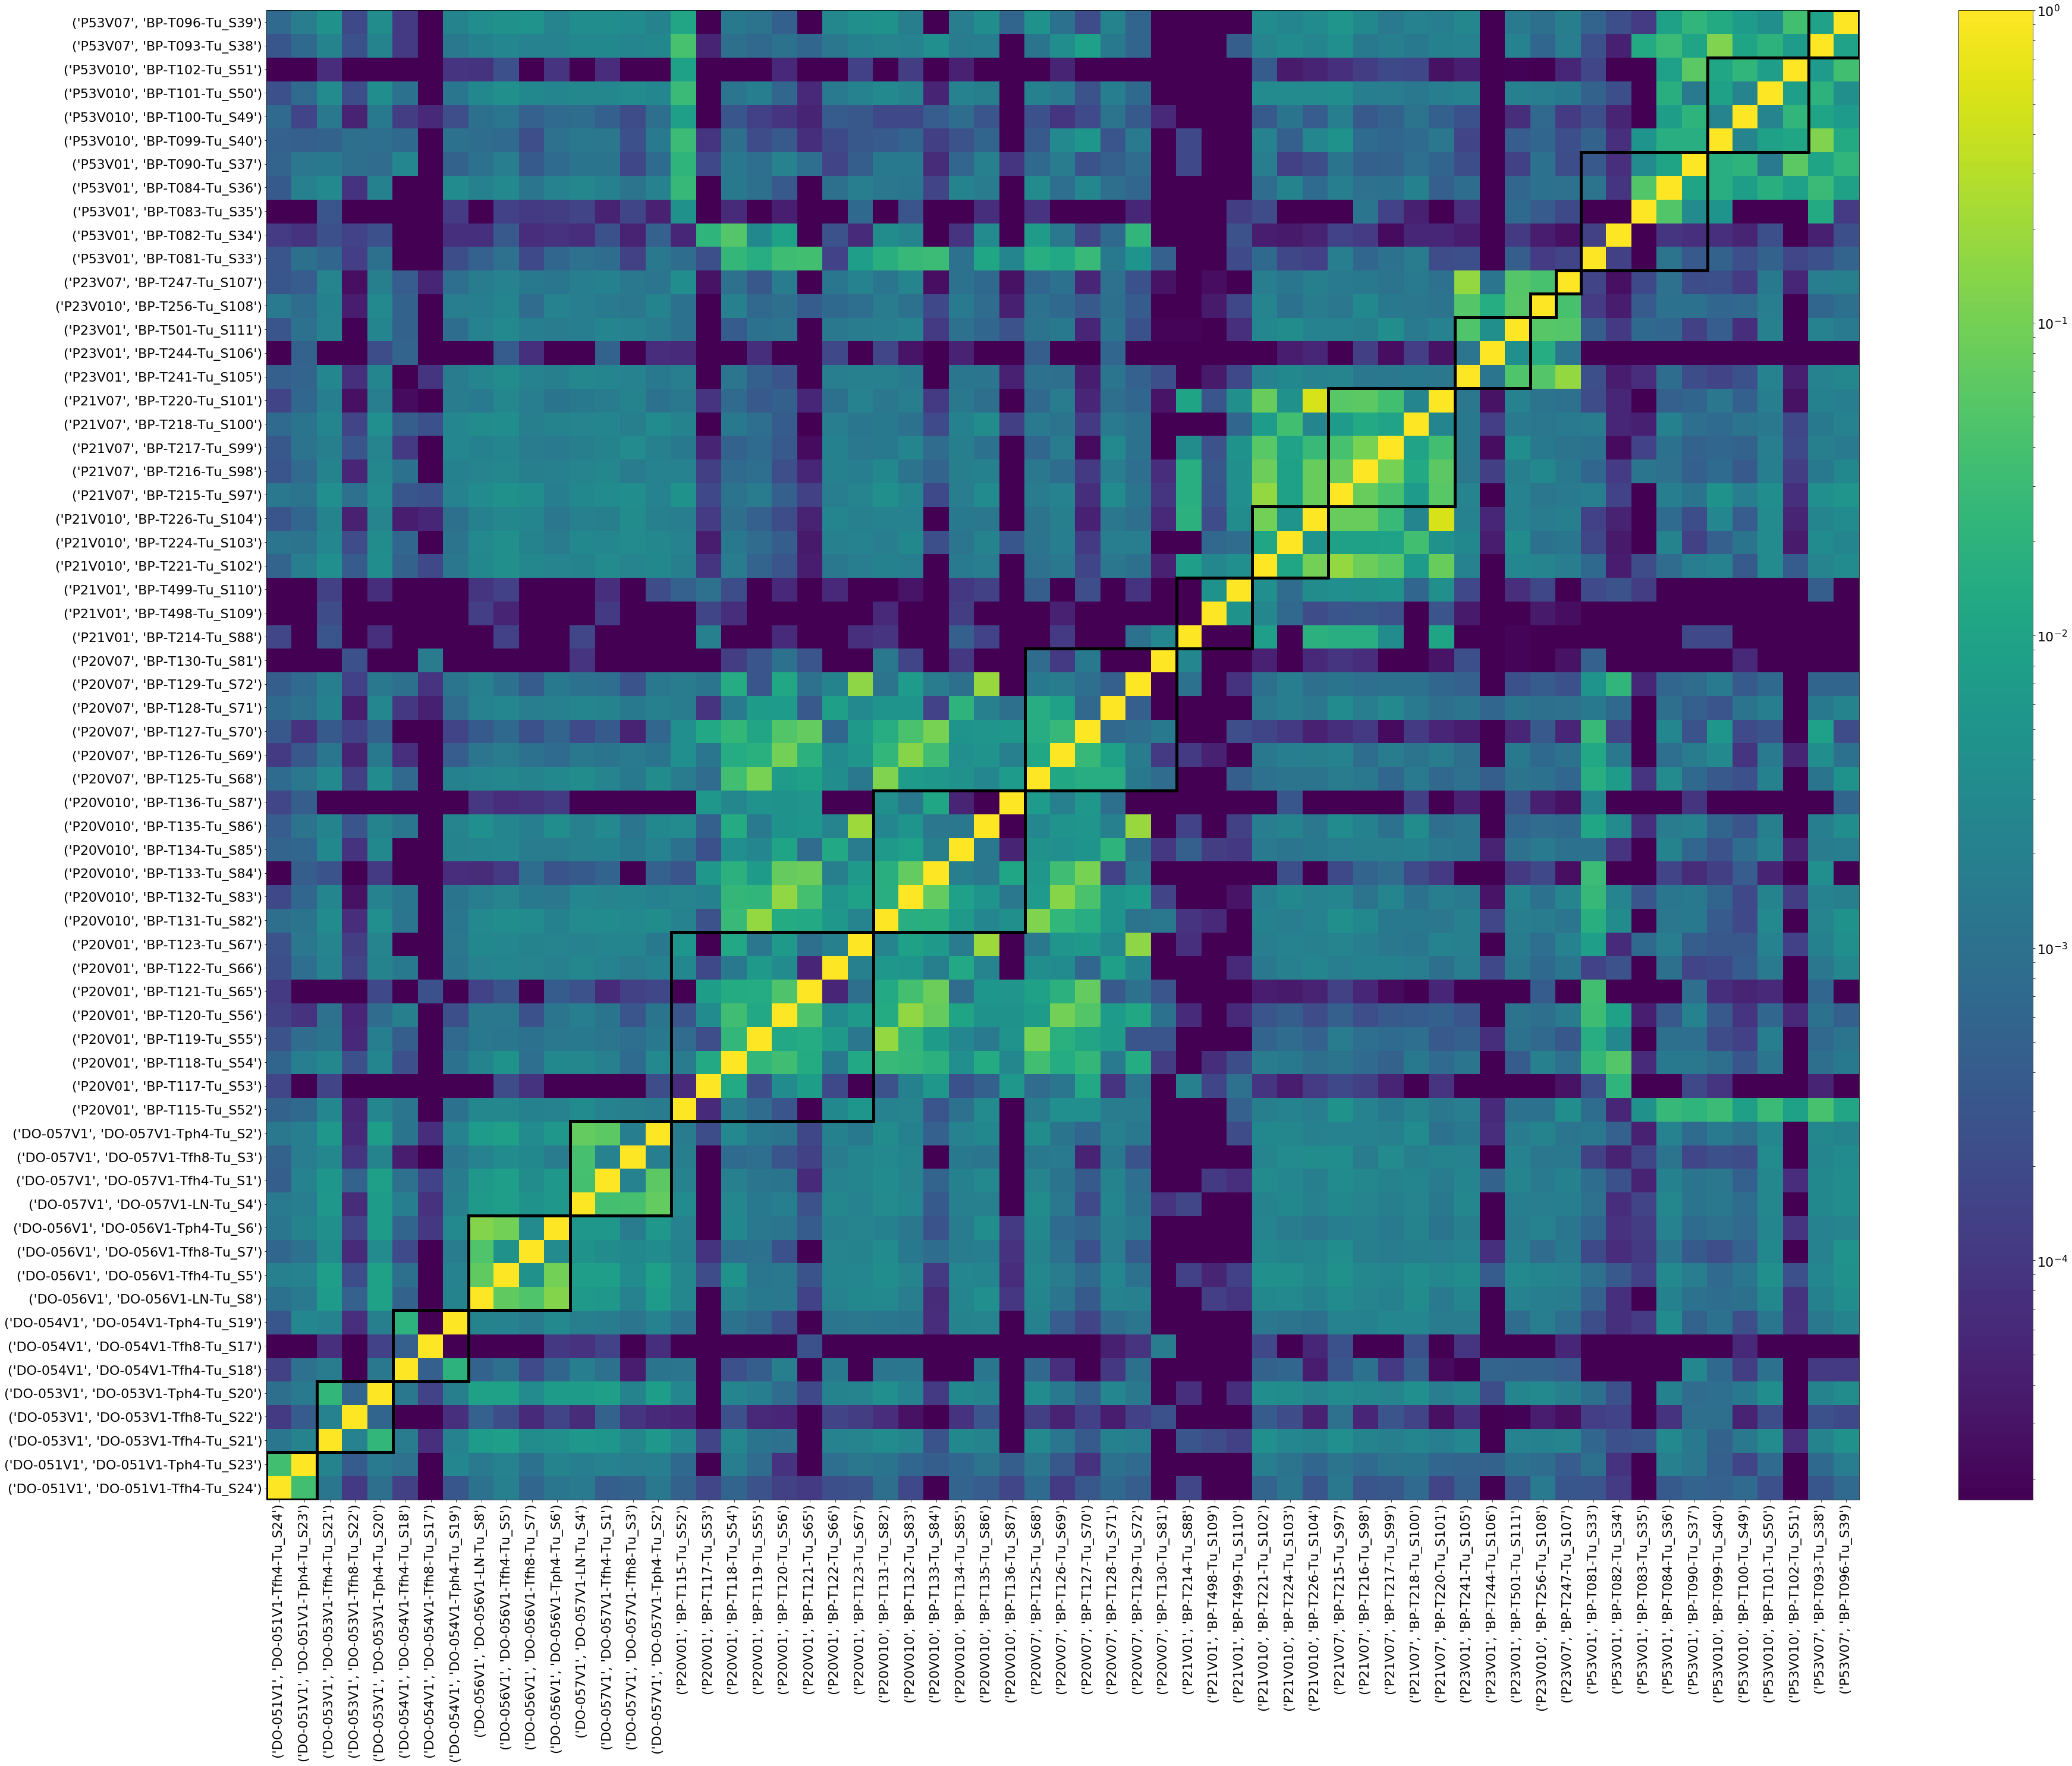

In [16]:
drawHeatmap(sim)

## Highlight anomalies

In [17]:
# get index pairs of same patient (divide same vs not same sample) and list indices for different patients
same_sample = list()
same_patient = list()
diff_patient = list()
for x in sim.index:
    for y in sim.columns:
        if x[0] == y[0]:  # same patient
            if x[1] == y[1]:  # same sample
                same_sample.append((x, y))
            else:        # same patient, but not same sample
                same_patient.append((x, y))
        else:             # not same patient
            diff_patient.append((x,y))                    

In [18]:
# Get values of same patient (but different samples) and values for different patients
values_same_patient = [sim.loc[x][y] for x,y in same_patient]
values_diff_patient = [sim.loc[x][y] for x,y in diff_patient]
mean_diff_patient = np.mean(values_diff_patient)
std_diff_patient = np.std(values_diff_patient)
threshold = mean_diff_patient + 4 * std_diff_patient
print("mean same patient", np.mean(values_same_patient), np.std(values_same_patient))
print("mean diff patient", mean_diff_patient, std_diff_patient)
print("threshold", threshold)

mean same patient 0.0161614409106785 0.025827929781163925
mean diff patient 0.003747107175700905 0.018671991016536747
threshold 0.0784350712418479


{'whiskers': [<matplotlib.lines.Line2D at 0x7fb60402eb00>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb5cdd88940>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb5cd7446a0>,
 'medians': [<matplotlib.lines.Line2D at 0x7fb5ccebf828>,
 'fliers': [<matplotlib.lines.Line2D at 0x7fb5ccebfe80>,
 'means': []}

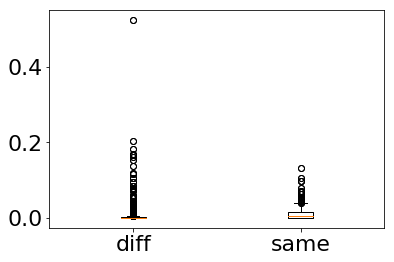

In [19]:
# Boxplot
plt.boxplot([values_diff_patient, values_same_patient], labels=['diff', 'same'])

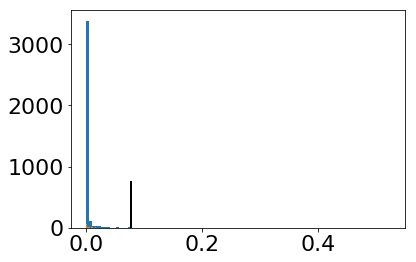

In [20]:
# Histogram
plt.hist(values_diff_patient, bins=100)
plt.hist(values_same_patient, bins=100)
plt.plot([threshold, threshold], [0, 750], 'k-', lw=2)

In [21]:
# Print sample names if similarity is twice the 95% interval
fhOut = open(suspects_list, "w")
check_samples = list()
for i,j in diff_patient:
    if sim.loc[i][j] > threshold:
        print(i, j, sim.loc[i][j])
        print(i, j, sim.loc[i][j], file=fhOut)
        check_samples.append((i,j))
fhOut.close()
print("Wrote", suspects_list, "to disk")

('P20V01', 'BP-T119-Tu_S55') ('P20V010', 'BP-T131-Tu_S82') 0.16844336123768144
('P20V01', 'BP-T119-Tu_S55') ('P20V07', 'BP-T125-Tu_S68') 0.1049541506521805
('P20V01', 'BP-T120-Tu_S56') ('P20V010', 'BP-T132-Tu_S83') 0.16265449423327438
('P20V01', 'BP-T120-Tu_S56') ('P20V07', 'BP-T126-Tu_S69') 0.09506569664599518
('P20V01', 'BP-T121-Tu_S65') ('P20V010', 'BP-T133-Tu_S84') 0.08482438701126571
('P20V01', 'BP-T123-Tu_S67') ('P20V010', 'BP-T135-Tu_S86') 0.20409437348802117
('P20V01', 'BP-T123-Tu_S67') ('P20V07', 'BP-T129-Tu_S72') 0.1523305084745763
('P20V010', 'BP-T131-Tu_S82') ('P20V01', 'BP-T119-Tu_S55') 0.16844336123768144
('P20V010', 'BP-T131-Tu_S82') ('P20V07', 'BP-T125-Tu_S68') 0.11922462308066417
('P20V010', 'BP-T132-Tu_S83') ('P20V01', 'BP-T120-Tu_S56') 0.16265449423327438
('P20V010', 'BP-T132-Tu_S83') ('P20V07', 'BP-T126-Tu_S69') 0.1377275679064872
('P20V010', 'BP-T133-Tu_S84') ('P20V01', 'BP-T121-Tu_S65') 0.08482438701126571
('P20V010', 'BP-T133-Tu_S84') ('P20V07', 'BP-T127-Tu_S70')

In [22]:
sim2 = sim.copy()
for i, j in check_samples:
    sim2.loc[i][j] = 1

min value: 1.7181835363699882e-05
max value: 1.0
Wrote run42-similarity-TRB_HUMAN-highlighted.pdf to disk


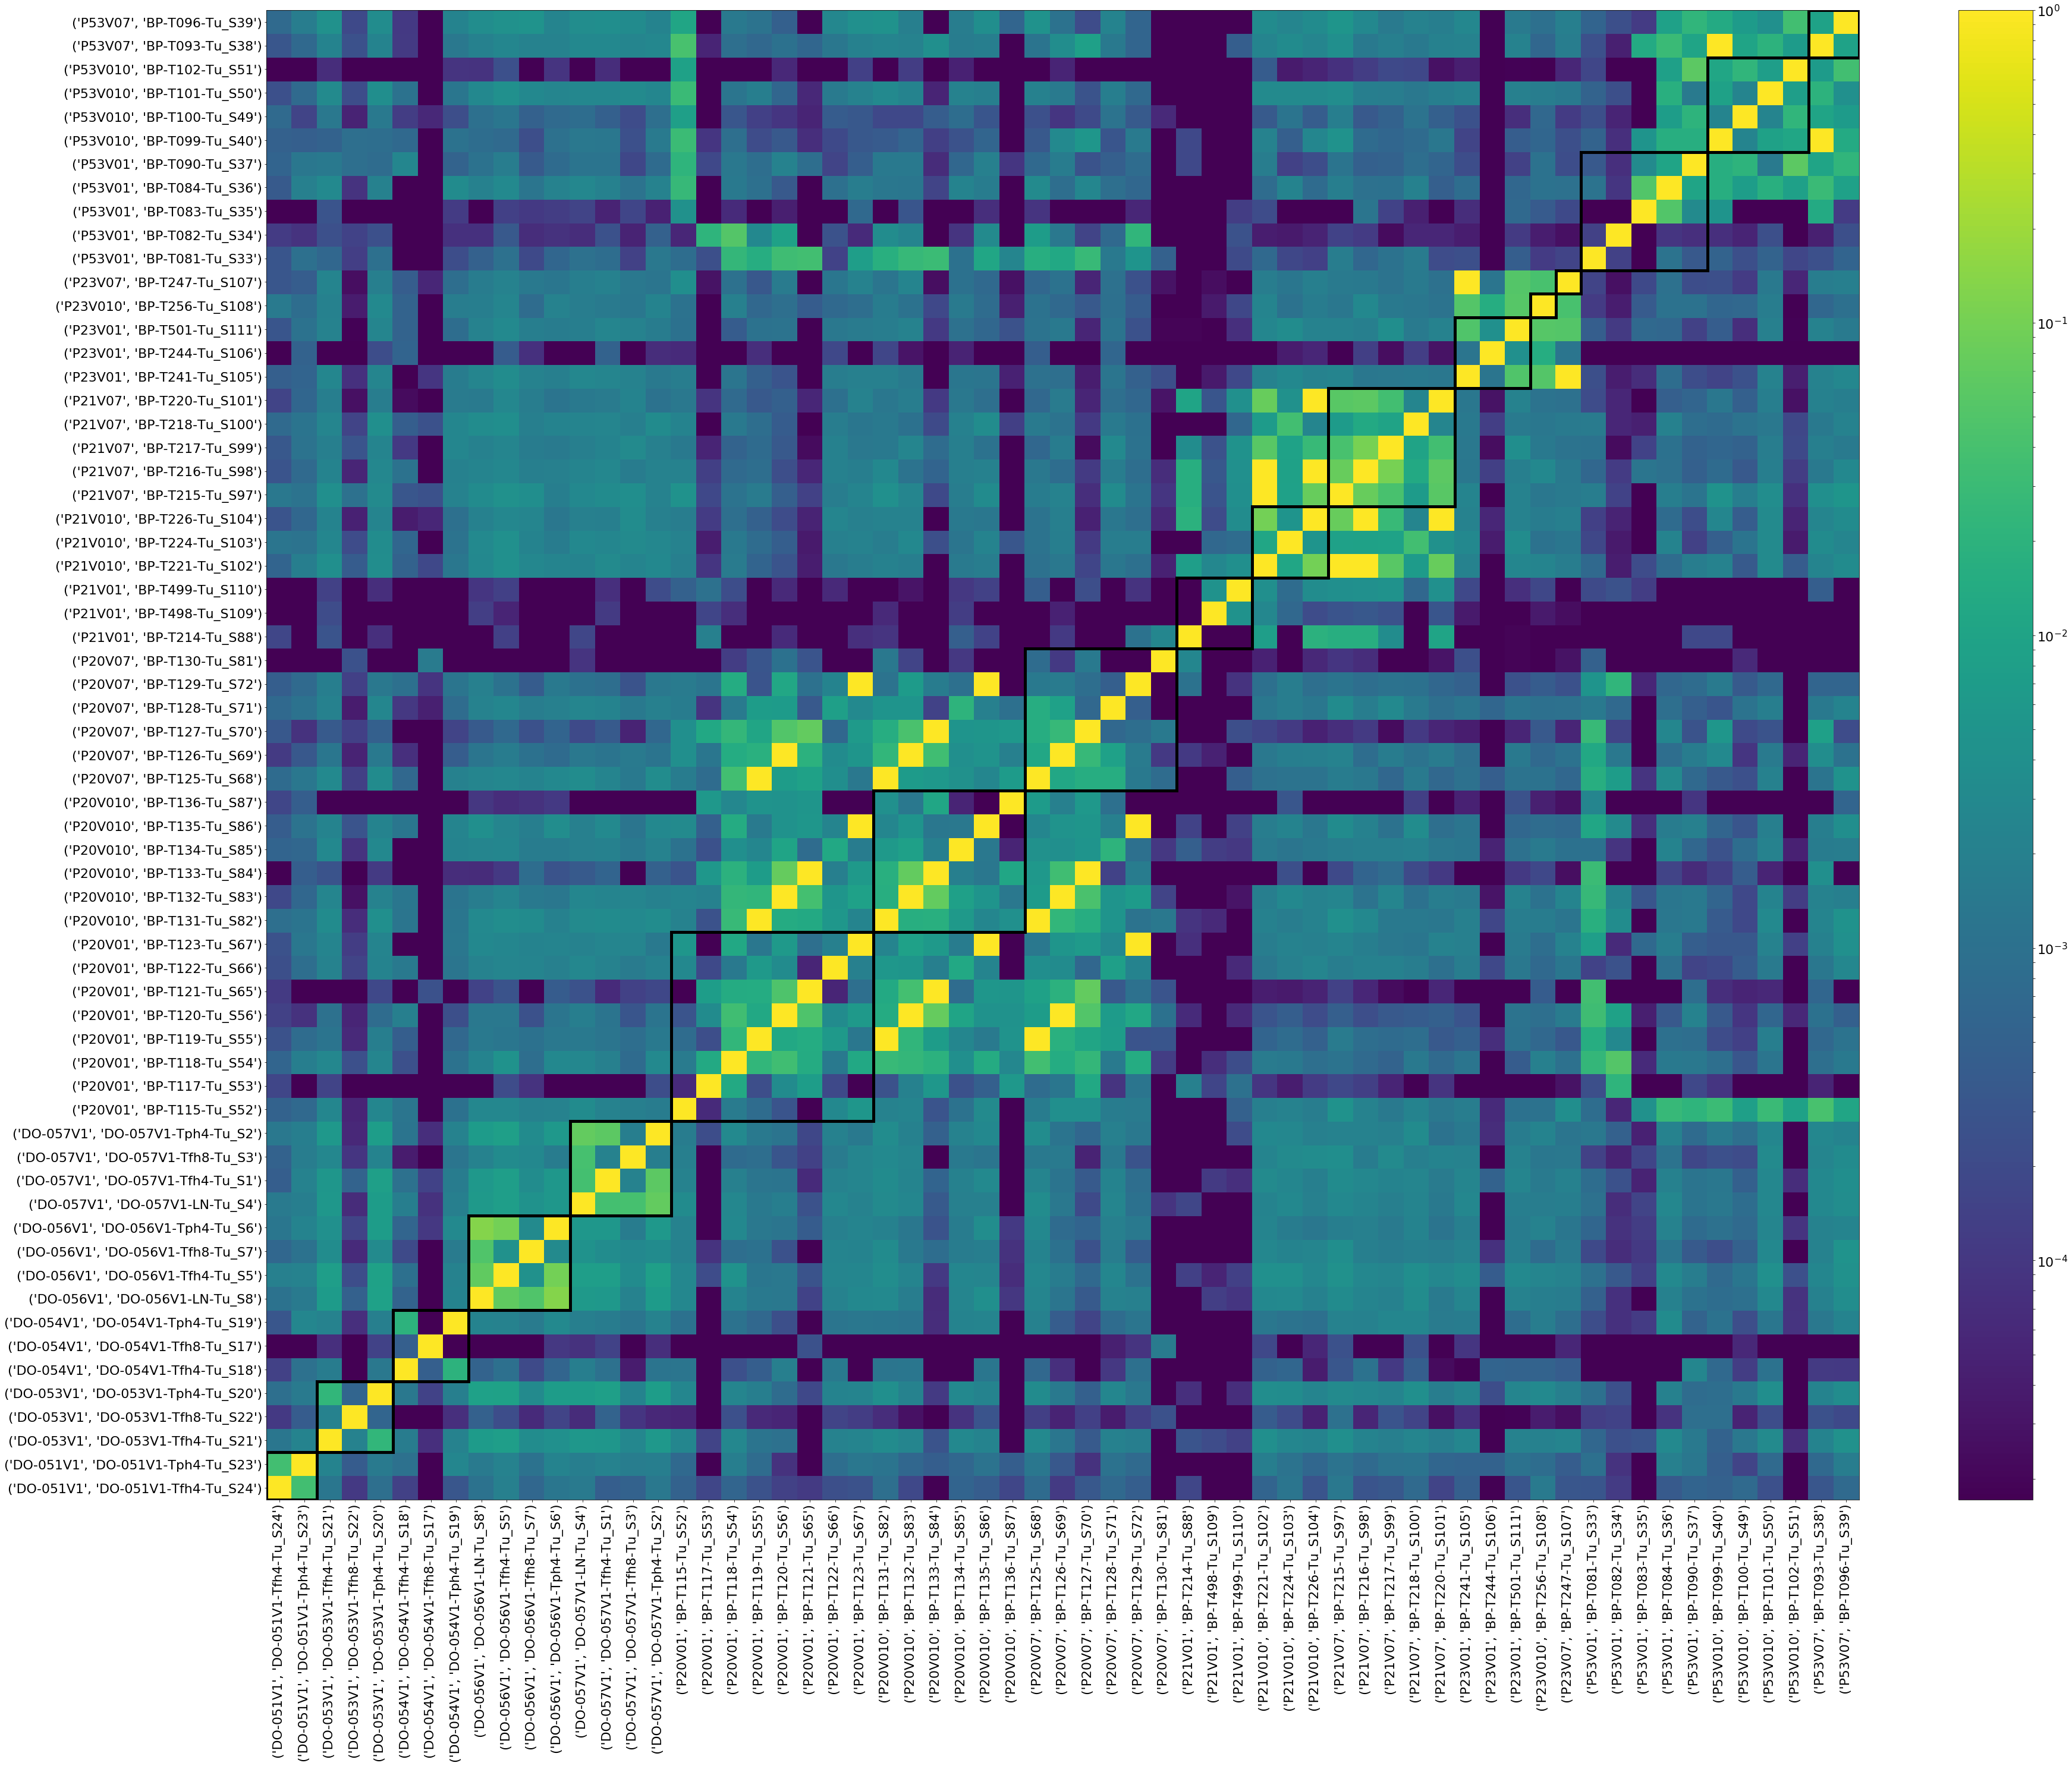

In [23]:
plotfile = plotfile.replace('.pdf', '-highlighted.pdf')
drawHeatmap(sim2)